# Home work 1: Basic Artificial Neural Networks

Credit https://github.com/yandexdataschool/YSDA_deeplearning17, https://github.com/DmitryUlyanov


Зачем это всё нужно?! Зачем понимать как работают нейросети внутри когда уже есть куча библиотек?
- Время от времени Ваши сети не учатся, веса становятся nan-ами, все расходится и разваливается -- это можно починить если понимать бекпроп
- Если Вы не понимаете как работают оптимизаторы, то не сможете правильно выставить гиперапрааметры :) и тоже ничего выучить не выйдет
- https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- hw1_Modules.ipynb

If you want to read more about backprop this links can be helpfull:
- http://udacity.com/course/deep-learning--ud730 
- http://cs231n.stanford.edu/2016/syllabus.html 
- http://www.deeplearningbook.org 

<h1 align="center">Check Questions</h1> 

**Вопрос 1**: Чем нейросети отличаются от линейных моделей а чем похожи? 

Нейросеть - это бутерброд из линейных моделей. И колбасой из нелинейностей.

**Вопрос 2**: В чем недостатки полносвзяных нейронных сетей какая мотивация к использованию свёрточных?

В сверточной сети меньше весов. Сверточные сети менее чувствительны к сдвигам и искажениям, т.к. используют локальные закономерности.

**Вопрос 3**: Какие слои используются в современных нейронных сетях? Опишите как работает каждый слой и свою интуицию зачем он нужен.

    - DenceLayer -- линейное преобразование Wx + b, можно интерпретировать как ..., а так-же хорошо подходит тут ..., очень похож на линейную алгебру и по этому работает так ...
    
    - <Тут Ваш слой>
    - <Тут Ваш слой>
    - <Тут Ваш слой>
    - <Тут Ваш слой>
    
    
**Вопрос 4**: Может ли нейросеть решать задачу регрессии, какой компонент для этого нужно заменить в нейросети из лекции 1?

в выходном слое, вместо sigmoid / softmax убираем нелинейность.

**Вопрос 5**: Почему обычные методы оптимизации плохо работают с нейросетями? А какие работают хорошо? Почему они работают хорошо?

Методы второго порядка работают слишком долго.

**Вопрос 6**: Для чего нужен backprop, чем это лучше/хуже чем считать градиенты без него? Почему backprop эффективно считается на GPU?

<Ответ>

**Вопрос 7**: Почему для нейросетей не используют кросс валидацию, что вместо неё? Можно-ли ее использовать?

Нейросети часто тренируют неделями, делать KFold просто слишком медленно. Использують train/valiation/test split.
Validation - для подбора параметров, Тест - для финальной оценки модели.

**Вопрос 8**: Небольшой quiz который поможет разобраться со свертками https://www.youtube.com/watch?v=DDRa5ASNdq4 

<img src="conv.png" width="600">

<Ответ-Картинка :)> Да легко!
<img src="conv_answer.png" width="600">


-------------

Политика списывания. Вы можете обсудить решение с одногрупниками, так интереснее и веселее :) 
Не шарьте друг-другу код, в этом случаи вы ничему не научитесь -- "мыши плакали кололись но продолжали жрать кактус".

Теперь формально. Разница между списыванием и помощью товарища иногда едва различима. Мы искренне надеемся, что при любых сложностях вы можете обратиться к семинаристам и с их подсказками **самостоятельно** справиться с заданием. При зафиксированных случаях списывания (одинаковый код, одинаковые ошибки), баллы за задание будут обнулены всем участникам инцидента.

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [256]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run hw1_Modules.ipynb

In [3]:
import numpy as np
from scipy.optimize import check_grad
from gradient_check import eval_numerical_gradient_array

def rel_error(x, y):
      return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))
    
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
                    / predictions.shape[0])

Optimizer is implemented for you. 

In [4]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

In [5]:
def adam(x, dx, config, state):
    # Your answer goes here. ################################################
    pass

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

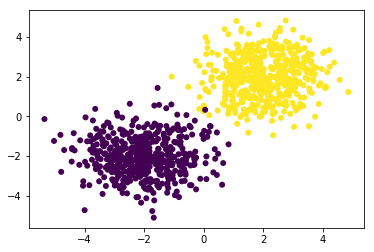

In [6]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

train_dataset = {}
train_dataset['X'] = X
train_dataset['y'] = Y

Define a **logistic regression** for debugging. 

In [7]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())
print net

net2 = Sequential()
net2.add(Linear(2, 4))
net2.add(ReLU())
net2.add(Linear(4, 2))
net2.add(SoftMax())
print net2

criterion = MSECriterion()

Linear 2 -> 2
SoftMax

Linear 2 -> 4
ReLU
Linear 4 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [8]:
# Looping params
n_epoch = 20
batch_size = 128

In [80]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [273]:
def train(net, train_dataset, test_dataset=None, viz='loss', config = None, batch_generator = get_batches):
    
    X, Y = train_dataset['X'], train_dataset['y']

    # Optimizer params
    if config == None:
        optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9, 'lr_drop': 1.0, 'batch_size': 128, 'n_epoch': 20}
    else: 
        optimizer_config = config
        
    optimizer_state = {}

    loss_history = []
    acc_history = []
    
    def final_print():   
        # Visualize
        plt.figure(figsize=(8, 6))
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()
        print('Current loss: %f' % loss_history[-1]) 

        if viz == 'acc' and test_dataset!=None:
            # Visualize
            plt.figure(figsize=(8, 6))
            plt.title("Accuracy")
            plt.xlabel("#iteration")
            plt.ylabel("accuracy")
            plt.plot(acc_history, 'b')
            plt.show()

            print('Current accuracy: %f' % acc_history[-1]) 

    
    try:
        for i in range(optimizer_config['n_epoch']):
            optimizer_config['learning_rate'] *= optimizer_config['lr_drop']
            step = 0
            for x_batch, y_batch in batch_generator((X, Y), optimizer_config['batch_size']):
                step += 1
                net.zeroGradParameters()
                net.training
                
                # Forward
                predictions = net.forward(x_batch)
                loss = criterion.forward(predictions, y_batch)

                # Backward
                dp = criterion.backward(predictions, y_batch)
                net.backward(x_batch, dp)

                # Update weights
                sgd_momentum(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)      

                loss_history.append(loss)

                if viz == 'loss' and step%10 == 0:
                    # Visualize
                    display.clear_output(wait=True)
                    plt.figure(figsize=(8, 6))
                    plt.title("Training loss")
                    plt.xlabel("#iteration")
                    plt.ylabel("loss")
                    plt.plot(loss_history, 'b')
                    plt.show()

                    print('Current loss: %f' % loss) 

            if viz == 'acc' and test_dataset!=None:
                net.evaluate
                acc_history.append(accuracy(net.forward(test_dataset['X']), test_dataset['y']))
                # Visualize
                display.clear_output(wait=True)
                plt.figure(figsize=(8, 6))
                plt.title("Accuracy")
                plt.xlabel("#iteration")
                plt.ylabel("accuracy")
                plt.plot(acc_history, 'b')
                plt.show()
            
    except KeyboardInterrupt:
        display.clear_output(wait=True)
        print('training interrupted')
        final_print()   
        return [loss_history, acc_history]

    display.clear_output(wait=True)
    print('training finished')
    final_print()
    return [loss_history, acc_history]


training interrupted


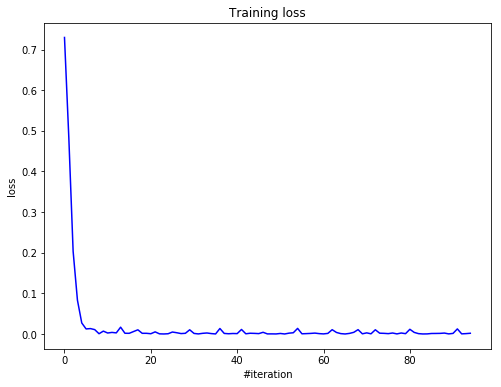

Current loss: 0.001750


In [76]:
_ = train(net, train_dataset)

training interrupted


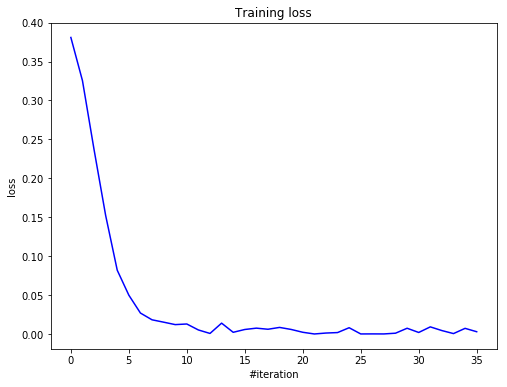

Current loss: 0.002938


In [77]:
_ = train(net2, train_dataset)

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [11]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X_train = data['train'] / 255.0
        y_train = data['train_labels']
        X_test = data['test'] / 255.0
        y_test = data['test_labels']

#else:
#    mnist = fetch_mldata("mnist-original")
#    X, y = mnist.data / 255.0, mnist.target
#    np.savez('mnist.npz', X=X, y=y)

y_train = y_train[0]
y_test = y_test[0]

One-hot encode the labels first.

In [12]:
# Your code goes here. ################################################
y_train = np.eye(10)[np.array(y_train, dtype=np.int32)]
y_test = np.eye(10)[np.array(y_test, dtype=np.int32)]

In [13]:
train_ds_mnist = {'X':X_train.T, 'y':y_train}
test_ds_mnist = {'X':X_test.T, 'y':y_test}

- **Compare** `ReLU`, `ELU` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.

<img src="activations.jpg" width="600">

In [ ]:
# Your code goes here. ################################################

In [212]:
mnist_net_relu = Sequential()
mnist_net_relu.add(Linear(784, 128))
mnist_net_relu.add(ReLU())
mnist_net_relu.add(Linear(128, 10))
mnist_net_relu.add(SoftMax())
criterion = NLLCriterion()

training finished


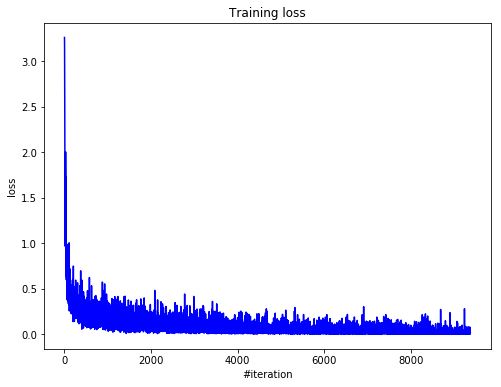

Current loss: 0.019500


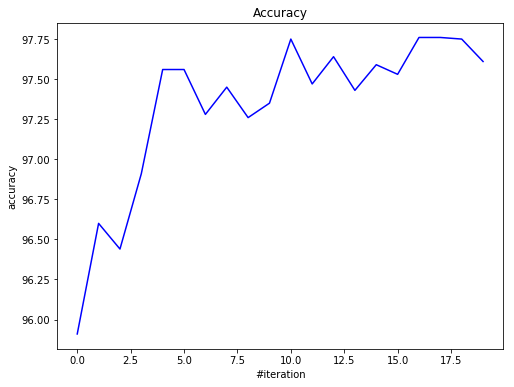

Current accuracy: 97.610000


In [213]:
_ = train(mnist_net_relu, train_ds_mnist, test_ds_mnist, viz = 'acc')

In [210]:
mnist_net_lrelu = Sequential()
mnist_net_lrelu.add(Linear(784, 128))
mnist_net_lrelu.add(LeakyReLU(slope = 0.1))
mnist_net_lrelu.add(Linear(128, 10))
mnist_net_lrelu.add(SoftMax())
criterion = NLLCriterion()

training finished


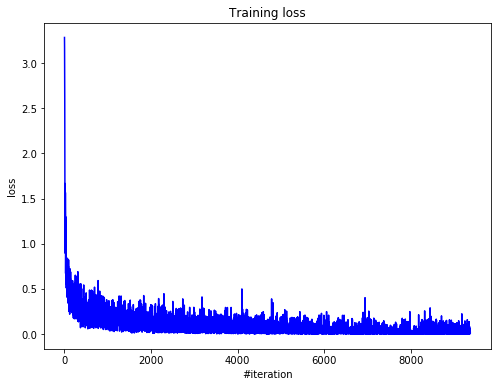

Current loss: 0.013184


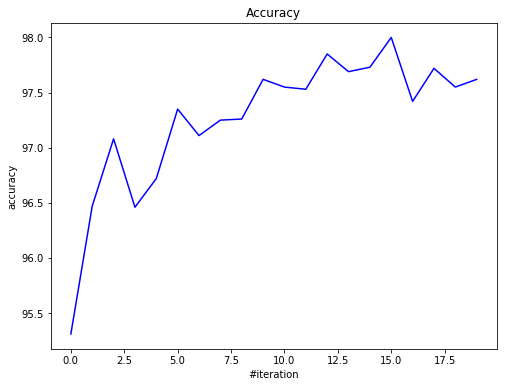

Current accuracy: 97.620000


In [211]:
_ = train(mnist_net_lrelu, train_ds_mnist, test_ds_mnist, viz = 'acc')

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [54]:
# Your code goes here. ################################################
mnist = Sequential()
mnist.add(Linear(784, 512))
mnist.add(Dropout(p=0.8))
mnist.add(ReLU())
mnist.add(Linear(512, 10))
mnist.add(SoftMax())
criterion = NLLCriterion()

training finished


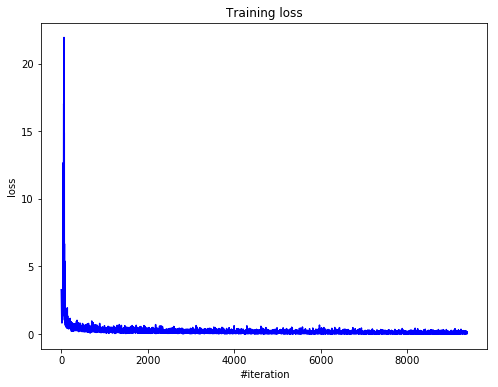

Current loss: 0.025384


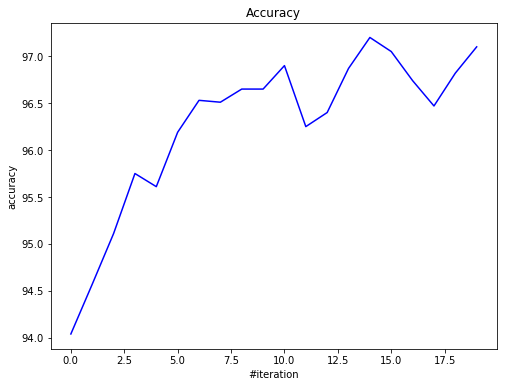

Current accuracy: 97.100000


In [55]:
_ = train(mnist, train_ds_mnist, test_ds_mnist, viz = 'acc')

Print here your accuracy. It should be around 90%.

Accuracy = 98 %

In [ ]:
# Your answer goes here. ################################################

**Оформление дз**: заполните форму тут https://goo.gl/forms/Jx3OR5Ijjg2MwfKs2 
----------
**PS**: Напоминаем, что дедлайны жесткие, прием дз заканчивается ровно в дедлайн

# Bonus Part: Autoencoder 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [305]:
# Your code goes here. ################################################
# Looping params
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.0, 'lr_drop': 0.8, 'batch_size': 256, 'n_epoch': 12}

# Your code goes here. ################################################
autoenc = Sequential()
autoenc.add(Linear(784, 256))
autoenc.add(LeakyReLU(slope = 0.05))
autoenc.add(Linear(256, 128))
autoenc.add(LeakyReLU(slope = 0.05))
autoenc.add(Linear(128, 30))
autoenc.add(LeakyReLU(slope = 0.05))
autoenc.add(Linear(30, 128))
autoenc.add(LeakyReLU(slope = 0.05))
autoenc.add(Linear(128, 256))
autoenc.add(LeakyReLU(slope = 0.05))
autoenc.add(Linear(256, 784))
mnist.add(Sigmoid())

criterion = MSECriterion()

In [306]:
# batch generator
def get_batches_autoenc(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], X[batch_idx]

training interrupted


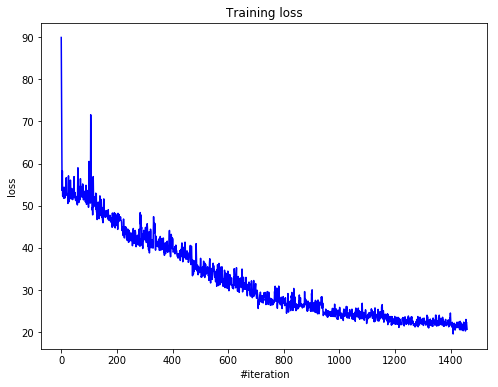

Current loss: 20.694011


In [307]:
_ = train(autoenc, train_ds_mnist, viz = 'loss', config = optimizer_config, batch_generator = get_batches_autoenc)

In [310]:
def plot(X,Y):
    """ Plot 4 images as gray scale. """
    plt.subplot(221)
    plt.imshow(X[0].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(222)
    plt.imshow(X[1].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(223)
    plt.imshow(Y[2].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(224)
    plt.imshow(Y[3].reshape(28,28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()

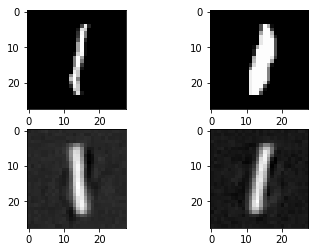

In [311]:
ind = np.random.randint(1,50000)
X = train_ds_mnist['X'][ind:ind+128,]
Y = autoenc.forward(X)
plot(X,Y)

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [320]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################
import copy 
repr = Sequential()
repr.add(copy.deepcopy(autoenc.modules[0]))
repr.add(copy.deepcopy(autoenc.modules[1]))
repr.add(copy.deepcopy(autoenc.modules[2]))
repr.add(copy.deepcopy(autoenc.modules[3]))
repr.add(copy.deepcopy(autoenc.modules[4]))

X = train_ds_mnist['X']
X_repr = repr.forward(X)
X_repr.shape

X_t = test_ds_mnist['X']
X_repr_t = repr.forward(X_t)
X_repr_t.shape

(10000, 30)

training finished


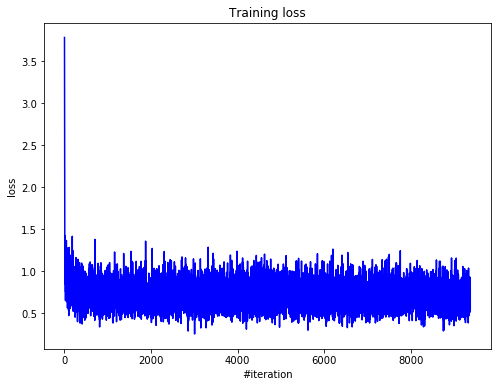

Current loss: 0.545135


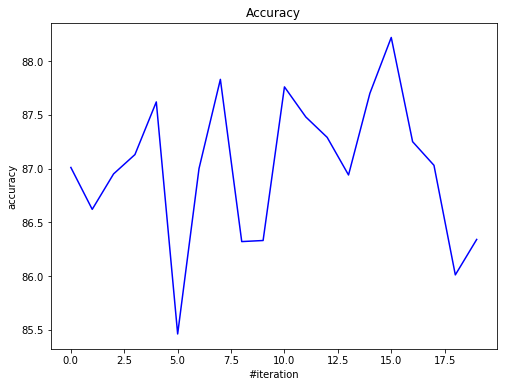

Current accuracy: 86.340000


In [317]:
# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(LeakyReLU(slope = 0.05))
cnet.add(Linear(30, 10))
cnet.add(SoftMax())
criterion = NLLCriterion()

train_ds = {'X':X_repr, 'y':y_train}
test_ds = {'X':X_repr_t, 'y':y_test}

# Learn the weights
# Your code goes here. ################################################
_ = train(cnet, train_ds, test_ds, viz = 'acc')

In [318]:
print cnet

LeakyReLU
Linear 30 -> 10
SoftMax



In [321]:
# And add learned layers ontop.
repr.add(copy.deepcopy(cnet.modules[0]))
repr.add(copy.deepcopy(cnet.modules[1]))
repr.add(copy.deepcopy(cnet.modules[2]))
print(repr)

Linear 784 -> 256
LeakyReLU
Linear 256 -> 128
LeakyReLU
Linear 128 -> 30
LeakyReLU
Linear 30 -> 10
SoftMax



In [322]:
criterion = NLLCriterion()

training finished


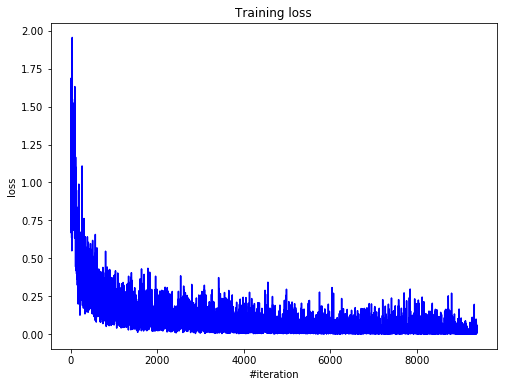

Current loss: 0.008880


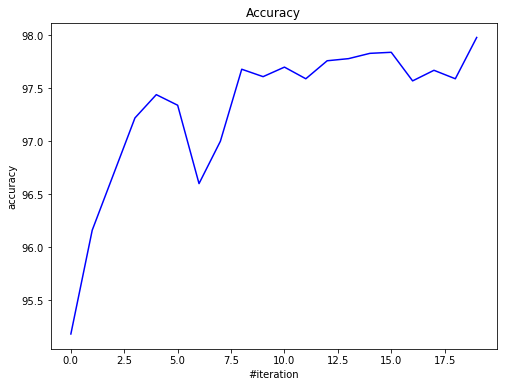

Current accuracy: 97.980000


In [323]:
_ = train(repr, train_ds_mnist, test_ds_mnist, viz = 'acc')

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [348]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################
from sklearn import decomposition

pca = decomposition.PCA(n_components=30)
pca.fit(X_train.T)
X = pca.transform(X_train.T)
X = np.round(pca.inverse_transform(X))

In [349]:
X_enc = np.round(autoenc.forward(X_train.T))

In [351]:
def plot_compare(X, X_enc, X_pca):
    index = np.random.randint(1,55000)
    """ Plot 4 images as gray scale. """
    plt.subplot(321)
    plt.imshow(X[index,].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(322)
    plt.imshow(X[index+1,].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(323)
    plt.imshow(X_enc[index,].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(324)
    plt.imshow(X_enc[index+1,].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(325)
    plt.imshow(X_pca[index,].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(326)
    plt.imshow(X_pca[index+1,].reshape(28,28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()   

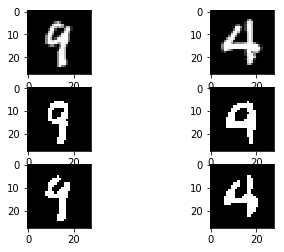

In [395]:
plot_compare(X_train.T, X_enc, X)